# IBM AI Workflow Specialization Capstone #

## Case Study (Part 2) ##

Time-series analysis is a subject area that has many varied methods and a great potential for customized solutions.
We cannot cover the breadth and depth of this important area of data science in a single case study. We do 
however want to use this as a learning opportunity if time-series analysis is new to you.  For those of you who are seasoned 
practitioners in this area, it may be a useful time to hone your skills or try out a more advanced technique like 
Gaussian processes.  The reference materials for more advanced approaches to time-series analysis will occur in their own section
below. If this is your first encounter with time-series data we suggest that that you begin with the supervised learning
approach before trying out the other possible methods. 

### Various modelling approaches ###

Ideally, I would like to try out at least 2 or 3 different modelling approaches to time-series data. Since I am relatively new to time-series analysis, applying a basic model like those available in the statsmodels package might be a good starting point. However, I am well versed in the domains of Bayesian modelling and would like to apply those methods to this data as well. 

Therefore, the approaches I will start out with to identify and model the business opportunity are:

1. Basic Approaches

    i. SARIMAX

    ii. ARIMAX
    
    iii. Seasonal ARIMAX
2. Bayesian Methods for time series

### Loading the data ###

In [1]:
import pandas as pd
import numpy as np
from load_data import load_data
from clean_data import clean_data
from prep_data import *
CSV_PATH = "time_series.csv"

In [2]:
DATA_DIR = "cs-train"
df = load_data(DATA_DIR)
df = clean_data(df)
merged_df = prepare_data(df)

We can also save the merged_df to a csv so that we only have to run the processing code once.

In [3]:
merged_df.to_csv(CSV_PATH)

In [46]:
df = pd.read_csv(CSV_PATH)
df.drop(df.columns[0], axis=1, inplace=True)
print(df.head())

         Date  Total Revenue  Total Unique invoices  Total Invoice Items  \
0  2017-11-28       41623.51                    166                 3223   
1  2017-11-29       37442.78                    133                 3277   
2  2017-11-30       40755.15                    150                 3002   
3  2017-12-01       30658.16                    107                 2559   
4  2017-12-02        8238.29                     32                  402   

   # Of Unique Content Streamed  Average items per invoice  
0                          1345                  19.415663  
1                          1397                  24.639098  
2                          1335                  20.013333  
3                          1256                  23.915888  
4                           287                  12.562500  


### Basic time-series modelling ###

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

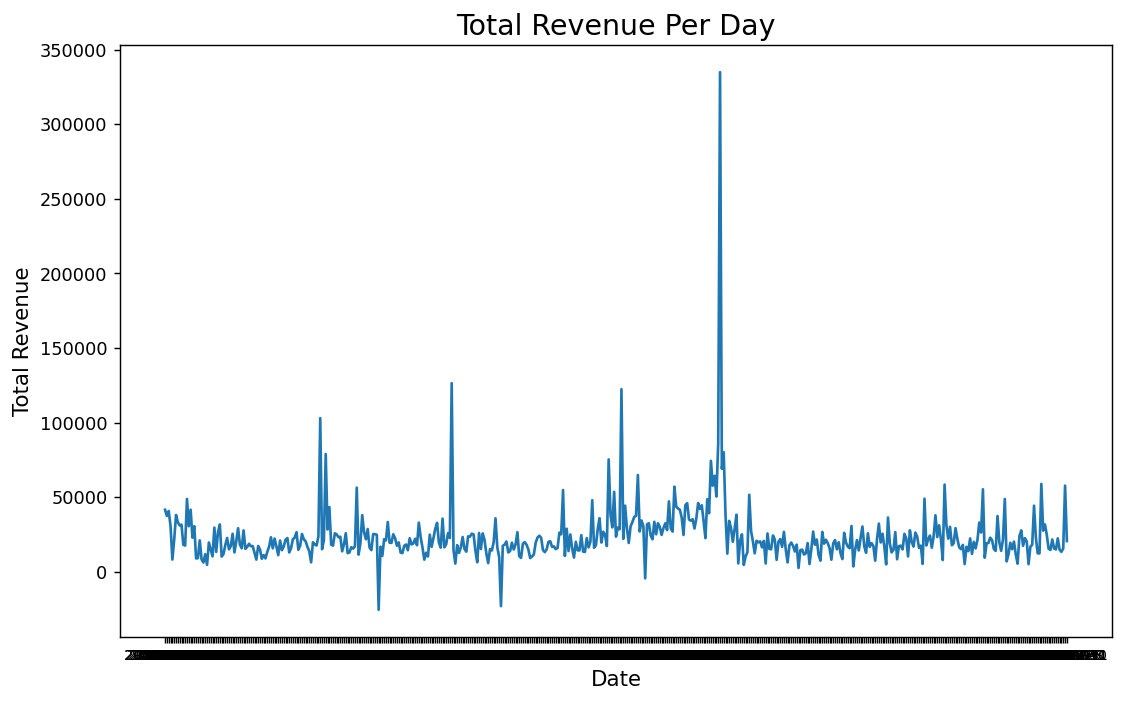

In [43]:
fig = plt.figure(dpi=128, figsize=(10,6))
plt.plot(df["Date"], df["Total Revenue"])
plt.title("Total Revenue Per Day", fontdict={"fontsize": 16})
plt.xlabel("Date", fontdict={"fontsize": 12})
plt.ylabel("Total Revenue", fontdict={"fontsize": 12})
plt.tick_params(axis='x', which='major', labelsize=8)
plt.show()

### Split data into training and testing datasets ###

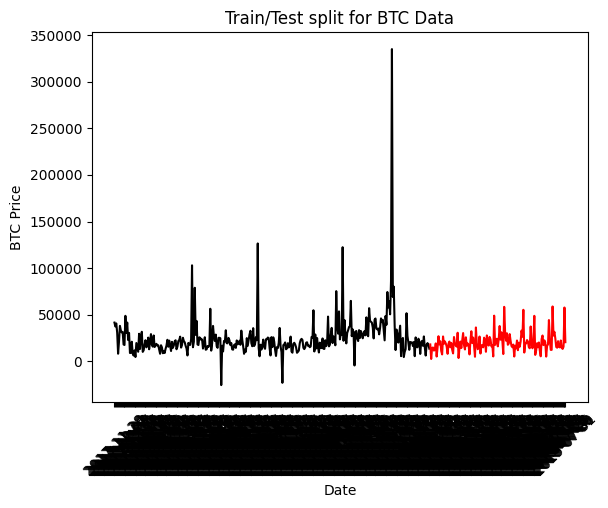

In [54]:
n = int(len(df)*0.7)
train = df[df.index < n]
test = df[df.index >= n]
train.index = train["Date"]
test.index = test["Date"]
plt.plot(train["Date"], train["Total Revenue"], color = "black")
plt.plot(test["Date"], test["Total Revenue"], color = "red")
plt.ylabel('BTC Price')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Train/Test split for BTC Data")
plt.show()

In [48]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA

The three basic models that can be used that statsmodels has are SARIMAX, ARIMA and Seasonal ARIMA.

### ARIMA ###
For ARIMA, there are three hyperparameters in the order that can be tuned:
Lagging, Differencing and White Noise.

We can tune these using an Sklearn grid search, and find the one that minimizes the RMSE. 

In [49]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

In [86]:
def build_time_series_pipeline(model_type, order, data):
    pipe = Pipeline([("time", model_type(data, order = order).fit()), ("predict", predict_with_time_series)])
    y_pred_out = pipe["predict"](pipe["time"])
    return pipe, y_pred_out

In [88]:
def predict_with_time_series(model):
    y_pred = model.get_forecast(len(test.index))
    y_pred_df = y_pred.conf_int(alpha = 0.05)
    y_pred_df["Predictions"] = model.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
    y_pred_out = y_pred_df["Predictions"]
    return y_pred_out

c:\Users\grego\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\grego\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\grego\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\tools.py:544: RuntimeWarning: invalid value encountered in sqrt
  x = r / ((1 - r**2)**0.5)
c:\Users\grego\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization

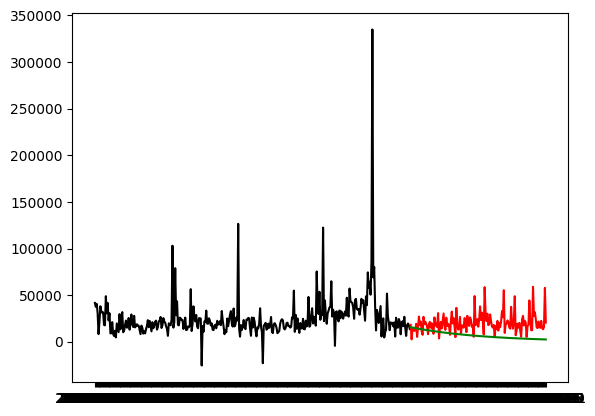

In [69]:
y = train["Total Revenue"]
pipe = Pipeline([("time", SARIMAX(y, order = (1, 0, 1))), ("predict", predict_with_time_series)])
pipe["time"].fit(y)
y_pred_out = pipe["predict"](pipe["time"])
plt.plot(train.index, train["Total Revenue"], color = "black")
plt.plot(test.index, test["Total Revenue"], color = "red")
plt.plot(y_pred_df.index, y_pred_out, color='green', label = 'Predictions')

In [91]:
def custom_grid_search(model, parameters, data, target_metric):
    best_model = None
    best_error = float("INF")
    for order in parameters["order"]:
        pipeline, predictions = build_time_series_pipeline(model, order, data)
        error = np.sqrt(target_metric(test["Total Revenue"].values, predictions))
        if error < best_error:
            best_error = error
            best_model = pipeline
    return best_model, best_error

c:\Users\grego\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\grego\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\grego\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\grego\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the 

10104.498589432764


c:\Users\grego\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\grego\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\grego\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\grego\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results wi

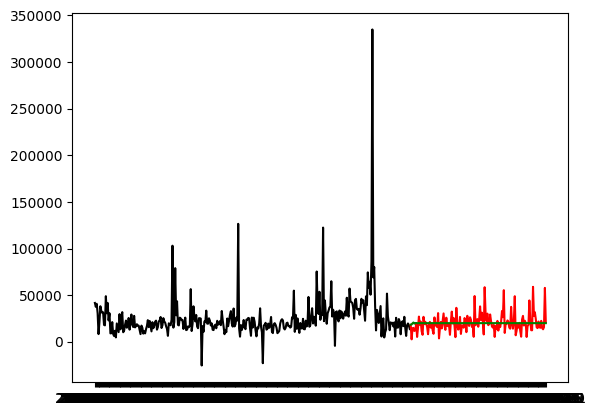

In [93]:
#Grid search
from sklearn.metrics import mean_squared_error
parameters = {"order": [(i, j, k) for i in range(1,5) for j in range(1,5) for k in range(1,5)]}
ARMAmodel = SARIMAX
best_pipe, best_error = custom_grid_search(ARMAmodel, parameters, y, mean_squared_error)
print(best_error)
y_pred_out = best_pipe["predict"](best_pipe["time"])
plt.plot(train.index, train["Total Revenue"], color = "black")
plt.plot(test.index, test["Total Revenue"], color = "red")
plt.plot(test.index, y_pred_out, color='green', label = 'Predictions')


c:\Users\grego\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\grego\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\grego\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\grego\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the 

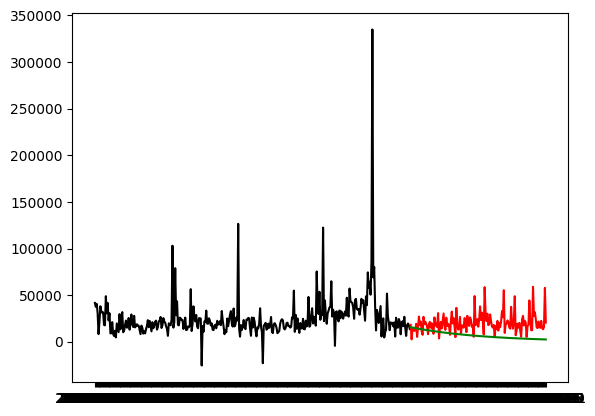

In [70]:
y = train["Total Revenue"]
ARMAmodel = SARIMAX(y, order = (1, 0, 1))
ARMAmodel = ARMAmodel.fit()
y_pred = ARMAmodel.get_forecast(len(test.index))
y_pred_df = y_pred.conf_int(alpha = 0.05)
y_pred_df["Predictions"] = ARMAmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_out = y_pred_df["Predictions"]
plt.plot(train.index, train["Total Revenue"], color = "black")
plt.plot(test.index, test["Total Revenue"], color = "red")
plt.plot(y_pred_df.index, y_pred_out, color='green', label = 'Predictions')

In [11]:
import numpy as np
from sklearn.metrics import mean_squared_error
arma_rmse = np.sqrt(mean_squared_error(test["Total Revenue"].values, y_pred_df["Predictions"]))
print("RMSE: ",arma_rmse)

RMSE:  17395.81366414085


### ARIMA model ###

c:\Users\grego\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


RMSE:  11058.130165328741


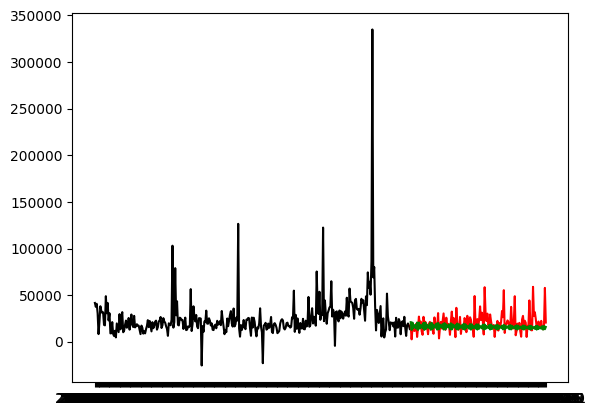

In [22]:
ARIMAmodel = ARIMA(y, order = (2, 2, 4))
ARIMAmodel = ARIMAmodel.fit()

y_pred = ARIMAmodel.get_forecast(len(test.index))
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df["Predictions"] = ARIMAmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df["Date"] = test["Date"]
y_pred_out = y_pred_df["Predictions"]
plt.plot(train["Date"], train["Total Revenue"], color = "black")
plt.plot(test["Date"], test["Total Revenue"], color = "red")
plt.plot(y_pred_df["Date"], y_pred_out, color='green', label = 'Predictions')

arma_rmse = np.sqrt(mean_squared_error(test["Total Revenue"].values, y_pred_df["Predictions"]))
print("RMSE: ",arma_rmse)

### Chart of hyperparameters ###
Lagging     Differencing        White Noise         RMSE
2           2                   2                   10948
3           2                   2                   10365
4           2                   2                   10711
5           2                   2                   11460
2           2                   3                   10978
2           2                   4                   11058